# Project 2: The two-dimensional Ising model


The Ising model is described by the classical Hamiltonian

\begin{equation}
  \mathcal{H} = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j
\end{equation}

where $\sigma_i=\pm1$ is an Ising spin on the site $i$ of a square
lattice and $J>0$ is a ferromagnetic coupling between nearest-neighbor
spins. The square lattice has $N = L \times L$ sites.

Onsager solved this problem analytically and showed that on the
infinite lattice ($N \rightarrow \infty$) there is a
phase transition at a temperature $T_c$ from a disordered state at high temperatures
to a magnetic state with finite magnetization $m \ne 0$ where

\begin{equation}
  \langle m \rangle = \lim_{N \rightarrow \infty}
     \frac{1}{N} \sum_{i=1}^N \langle \sigma_i \rangle
\end{equation}

The value of the critical temperature (we set $k_B=1$) is

\begin{equation}
  \frac{T_c}{J} = \frac{2}{\log (1 + \sqrt{2})} \simeq 2.27
\end{equation}

The goal of this project is to study the two-dimensional Ising model
using a Monte Carlo algorithm and see whether we can find evidences
for the phase transition even though we will be dealing with finite
systems.


In [1]:
import random as rnd
import numpy as np
from matplotlib import pyplot as plt
from scipy.constants import Boltzmann
from matplotlib.animation import FuncAnimation
from matplotlib.widgets import Slider
import itertools
from copy import deepcopy


%matplotlib widget

## Warmup: Compute $\pi$ by Monte Carlo

In order to get familiar with the generation of random numbers, you can try to write a
Monte Carlo algorithm to compute $\pi$. The idea, as we saw in the lecture, is to start
from a circle of radius 1, inside a square box of length 2. You then throw randomly
(uniformly) stones in the square box. After having thrown many stones you can compute
the ratio of those inside to those outside the circle. This will give you an estimate
for $\pi$.

*Challenge*: Show that the error bar on the value of $\pi$ goes like $1 / \sqrt{M}$, where
$M$ is the number of Monte Carlo steps. To do this, you will need to make several runs for
the same fixed $M$ and compute the statistical error bar.

In [22]:
def throwStone(lowerBound = -1, upperBound = 1):
    return np.random.uniform(lowerBound, upperBound, size=2)

In [23]:
def getPi(N = 10000):
    
    inside = 0
    
    for i in range(N):
        stone = throwStone()
        inside += (stone[0]**2 + stone[1]**2 <= 1)
    
    area = 4 * inside/N
    
    return area

Let us test this approach.

In [24]:
getPi()   # Looks good.

3.1356

Let us compute the empirical standard deviation of realizations of our random variable that is supposed to converge to a Gaussian random variable centered around $\pi$.

In [25]:
def computeStdDev(N, readings = 1000):
    
    measurements = np.zeros(readings)
    
    for i in range(readings):
        measurements[i] = getPi(N)
    
    stdDev = 0
    avgVal = np.sum(measurements)/readings
    
    for i in range(readings):
        stdDev += (measurements[i]-avgVal)**2
    
    return np.sqrt(stdDev/readings)
    

We are going to plot the reciprocal of the standard deviation squared:
$$
\sigma \propto \frac{1}{\sqrt{M}}\implies M\propto \frac{1}{\sigma^2}
$$

In [26]:
def plot_StdDev_N(lowerBound = 100, upperBound = 1100, step = 100):
    x = np.arange(lowerBound, upperBound, step)
    y_temp = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        y_temp[i] = computeStdDev(x[i])
    
    y = np.ones(x.shape[0])/(y_temp)**2
    plt.figure(figsize = (12,8))
    plt.plot(x,y)
    plt.show()

In [27]:
#plot_StdDev_N()

## Part 1: Set up a class for the Ising model

Let's first start and write a class that will describe the Ising model. The class
should have a constructor taking $T$, $J$ and $L$ as parameters and generate
a random initial state. The state can be encoded in an $L\times L\,$
```numpy.array```. The class could have a structure like

```python
class Configuration:
    def __init__(self, L, ...):
        self.size = L
        self.spins = ...
        ...
    def get_energy(self):
        ...
        return e
    def get_magnetization(self):
        ...
        return m
```

In order to test your class, you can instantiate it and plot the spin configuration
after the initialization. You can use the function below to convert your
spin configuration (with +1 and -1) into an image array:

```python
def config_to_image(config):
    L = config.size
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1.,0,0) if config.spins[i,j]==1 else (0.,0,0)
    return im
    
import matplotlib.pyplot as plt
plt.imshow(config_to_image(config))
```

You can also check your class methods by generating a configuration with all spins
up or down and see whether the energy and magnetization are those you expect.

We first define a Hamiltonian function for initial energy computation upon configuration initialization.

In [2]:
def isingHamiltonian(latticeArray, extFieldArray = None, E = 1, J = 0):    # Notice the wrap-around approximation!
    L = latticeArray.shape[0]
    energy = 0
    interparticle = 0
    external = 0
    for i in range(L):
        for j in range(L):
            interparticle -= latticeArray[i % L][j % L]*latticeArray[(i+1) % L][j % L]
            interparticle -= latticeArray[i % L][j % L]*latticeArray[i % L][(j+1) % L]
    interparticle *= E
    
    if extFieldArray is not None:
        for i in range(L):
            for j in range(L):
                external -= extFieldArray[i][j]*latticeArray[i][j]
        external *= J
        
    energy = interparticle + external
    
    return energy
                
    

In [3]:
def isingHamiltonianConfig(config):
    return isingHamiltonian(config.get_spins(), config.get_externalField(), config.get_E_param(), config.get_J_param())

In [4]:
def isingProbabilityNum(config):
    return np.exp(-(config.get_beta()*config.get_energy()))

In [5]:
K_b = 1

In [6]:
class Configuration:
    
    def __init__(self, L = 100, spins = None, extFieldArray = None, E = 1, J = 0, temperature = 273.0):
        self.size = L
        if spins is not None:
            self.spins = spins
        else:
            config = np.zeros(shape = (L,L))
            for i in range(L):
                for j in range(L):
                    config[i][j] = rnd.choice([-1,1])
            self.spins = config
        
        
            
        
        self.E = E
        self.J = J
        self.extFieldArray = np.zeros(shape = (L,L)) if extFieldArray is None else extFieldArray
        self.T = temperature
        self.beta = 1/(K_b * self.T)
        self.energy = isingHamiltonian(self.spins, self.extFieldArray, self.E, self.J)
    
    def get_energy(self):
        
        return self.energy
    
    def get_magnetization(self):
        
        totalMag = 0
        for i in range(self.size):
            for j in range(self.size):
                totalMag += self.spins[i][j]
        
        return totalMag
    
    def set_energy(self, energy = None):
        if energy is not None:
            self.energy = energy
        
        else:
            self.energy = isingHamiltonian(self.spins, self.extFieldArray, self.E, self.J)
        
    def set_externalField(self, extField):
        self.extFieldArray = extField
        
    def set_temperature(self, temperature):
        self.T = temperature
    
    def get_temperature(self):
        return self.T
    
    def get_E_param(self):
        return self.E
    
    def set_E(self, value):
        self.E = value
    
    def set_J(self, value):
        self.J = value
    
    def get_J_param(self):
        return self.J
    
    def toggle_spin(self, i, j):
        self.spins[i][j] *= (-1)
        
    def get_spins(self):
        return self.spins
    
    def get_externalField(self):
        return self.extFieldArray
    
    def get_beta(self):
        return self.beta
    
    def get_size(self):
        return self.size
    
    def reset_beta(self):
        self.beta = 1/ (K_b * self.T)

In [7]:
def config_to_image(config):
    L = config.size
    im = np.zeros([L,L,3])
    for i,j in itertools.product(range(L), repeat=2):
        im[i,j,:] = (1.,0,0) if config.spins[i,j]==1 else (0.,0,0)
    return im

In [34]:
# config = Configuration(3)

In [35]:
# plt.close()

In [36]:
# config = metropolis_move(config)
# plt.imshow(config_to_image(config))
# plt.show()

## Part 2: The Metropolis move

Here you will write a function that performs a Metropolis Monte Carlo
move on the configuration. The function takes an Ising configuration
(an instance of the `Configuration` class) as an argument and has
the following signature:

```python
def metropolis_move(config):
    ...
```

The function should chose a random site, compute the energy difference
between the old configuration and the new configuration where the spin
has been flipped and decide whether the move should be accepted or
not (using the Metropolis algorithm). Warning: in order to compute the
energy difference, only consider the energy change from the links involving
the flipped spin. Indeed, all the other links are unchanged and it would
be a waste of time to recompute the full energy every time.

How to check? Start from a small lattice, say $4 \times 4$, and call
`metropolis_move` many times at a rather high temperature. This way,
you should sample many different configuration. If you energy calculation
is right, the energy per spin should always be between -2 and 2.

In [8]:
def metropolis_move_0(config):    #Toggle one spin
    L = config.get_size()
    toggleLocation = (rnd.choice(np.arange(L)), rnd.choice(np.arange(L)))
    lattice = config.get_spins()
    x, y = toggleLocation
    spin_atLoc = lattice[x][y]
    change = spin_atLoc * (lattice[(x-1)%L][y]  + lattice[(x+1)%L][y] + lattice[x][(y-1)%L] + lattice[x][(y+1)%L])
    change *= config.get_E_param()
    change *= 2
    change += 2 * config.get_J_param() * config.get_externalField()[x][y] * lattice[x][y]
    
    A = np.exp(config.get_beta()*(-(change)))
    if rnd.uniform(0,1) < A:
        config.toggle_spin(x, y)
        config.set_energy(config.get_energy()+change)
    

In [9]:
def metropolis_move_1(config):   #Global change
    newConfig = Configuration(L = config.get_size(), extFieldArray = config.get_externalField(), E = config.get_E_param(), J = config.get_J_param(), temperature = config.get_temperature())
    A = isingProbabilityNum(newConfig)/isingProbabilityNum(config)
    if rnd.uniform(0,1) < A:
        config = newConfig

In [10]:
def metropolis_move(config, protocol = 0):
    if protocol == 0:
        metropolis_move_0(config)
    elif protocol == 1:
        metropolis_move_1(config)
    else:
        print("Please provide valid protocol.")
    

## Part 3: The Monte Carlo simulation live!

Write an animation that shows the evolution of the spins. In order for the animation not to be
too slow, the function that is repeatedly called by `FuncAnimation` should make many spin
flip trials (typically $L\times L$). Otherwise the animation will be really slow. You might want to get
more details about the function `matplotlib.animation.FuncAnimation` on the matplotlib
website.

See how the system behaves for different:

- Temperatures
- System sizes

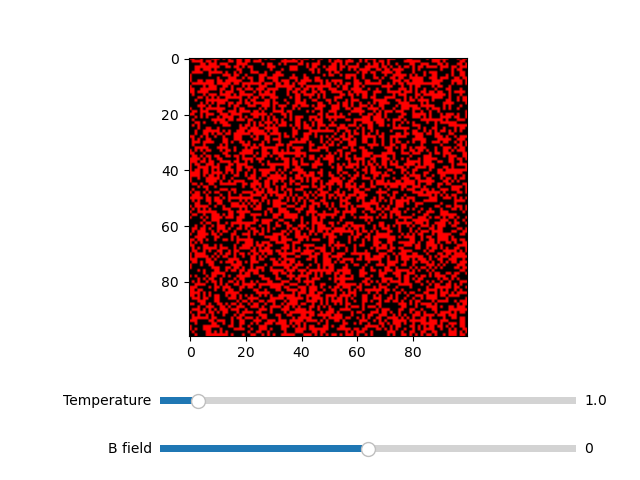

In [20]:
frames = 500
# energy_scale = 50

fig, ax = plt.subplots()
plt.subplots_adjust(bottom=0.3) # right=0.5,

config = Configuration(L = 100, E = 1, J = 0, extFieldArray = np.ones(shape = (100,100)), temperature = 1)

lattice = ax.imshow(config_to_image(config), animated=True)

initial_T = 1
ax_slider_T = plt.axes([0.25, 0.15, 0.65, 0.03])
T_slider = Slider(ax_slider_T, 'Temperature', valmin=0.1, valmax=300, valinit=initial_T)

initial_J = 0
ax_slider_J = plt.axes([0.25, 0.05, 0.65, 0.03])
J_slider = Slider(ax_slider_J, 'B field', valmin=-10, valmax=10, valinit=initial_J)

# ax_energy = plt.axes([0.6, 0.6, 0.3, 0.235])
# ax_energy.set_xlim([0, energy_scale])
# ax_energy.set_ylim([-200, 200])
# energy = np.zeros(frames)
# energy_plt = ax_energy.plot([], [], '.')

def update(t):
    for _ in range(50): 
        metropolis_move(config)
    lattice.set_data(config_to_image(config))
    fig.canvas.draw_idle()
    return lattice #, energy_plt

def update_slider_T(val):
    config.set_temperature(val)
    config.reset_beta()
    fig.canvas.draw_idle()
    
def update_slider_J(val):
    config.set_J(val)
    fig.canvas.draw_idle()
    
T_slider.on_changed(update_slider_T)
J_slider.on_changed(update_slider_J)

ani = FuncAnimation(fig, update, frames=frames, blit = True, interval=20)

plt.show()

## Part 4: Compute physical averages

The animation above allows to get some insight into the physics of the
model. But it is necessary to compute some physical averages to understand
more. Because two configurations that only differ by a spin flip are very
correlated, one usually waits a certain number of steps before considering
a new configuration in the computation of an average. In practice, the
Monte Carlo simulation can be cut into cycles: a cycle is a certain number
of steps needed to decorrelate the configurations. Also, in the beginning of
the simulation, one needs to wait for the Markov chain to reach its stationary
distribution. These variables can be used:

- `length_cycle`: the number of steps between two *measurements*, i.e. between two
   configurations that are used to compute physical averages.

- `n_cyles`: the number of cycles used to compute the averages. This number
   corresponds to the number of measurements
   
- `n_warmup`: the number of cycles that are performed in the beginning of the
   simulation without any measurement. They are done so that the Markov
   chain reaches a stationary distribution.

You can now write a Monte Carlo simulation:

1. Compute the average magnetization $m$ as a function of the number of
  Monte Carlo steps on a $20 \times 20$ lattice. This will allow you to
  judge how many steps are necessary to reach equilibrium. How
  does this change with temperature and system size?

2. You can then more systematically compute the magnetization, the energy, the
  magnetic susceptibility and specific heat as a function of the temperature.
  Start with a rather small lattice $4 \times 4$ and then increase the size.
  How do these quantities vary?
  
You will see that these simulations can take some time. Rather than
plotting directly after the simulation is done, you might want to save
your averages into files and in another cell read the information from these
files to do the plots. It is very common to organize a numerical work like
this: a production part that generates the data and a postprocessing part
to do the plots etc. To save and read a numpy array you can use:

```python
  np.savetxt("my_file.dat", my_array)
  my_array = np.loadtxt("my_file.dat")
```

In [11]:
def getAverageMag(config, cycleNumber, warmupNumber,cycleLength = None, protocol = 0):
    
    cycleLength = config.get_size()**2 if cycleLength is None else cycleLength
    
    magArray = np.zeros(cycleNumber)
    
    for l in range(warmupNumber):
        for _ in range(cycleLength):
            metropolis_move(config, protocol)
    
    for i in range(cycleNumber):
        for _ in range(cycleLength):
            metropolis_move(config, protocol)
        
        magArray[i] = config.get_magnetization()
    
    return (np.sum(magArray))/cycleNumber


#Must Subsequently Check When Equilibrium is Reached and Record!

## Part 5: Autocorrelation time

Above we said that configurations that differ only by a spin flip are very correlated
and that a certain number of moves are needed to make two configurations
independent. As a rule of thumb, we used $L\times L$ updates to disentangle
configurations.

However, as we will see here, as one gets closer to the phase transition, it becomes
harder and harder to decorrelate two configurations. A way to measure this in
the disordered state is to compute the *autocorrelation time* through the quantity

\begin{equation}
  \mathcal{C}(t) = \langle m(t) \, m(0) \rangle
\end{equation}

where $m(t)$ is the magnetization of the system at (Monte Carlo) time $t$.
If two configurations are completely decorrelated $\mathcal{C(t)}$ should
be zero. Usually $\mathcal{C}(t) \sim \exp(-t / \tau)$ where $\tau$ is the
autocorrelation time.

Write a code that computes the autocorrelation time at a given temperature
and study it as the temperature is reduced closer to the critical
temperature. You can start with an $8 \times 8$ lattice.

In [12]:
def ACF(magTimeSeries, lagT):   #Assumed warmed up configuration
    
    if lagT >= magTimeSeries.shape[0]:
        print("Please choose a lag smaller than sequence length.")
        return
    
    if lagT <= 0:
        print("Please choose a lag greater or equal to 1.")
        return
    
    N = magTimeSeries.shape[0]
    seriesAvg = np.sum(magTimeSeries)/N
    
    firstFactors = np.zeros(N - lagT)
    secondFactors = np.zeros(N - lagT)
    
    for i in range(N - lagT):
        
        firstFactors[i] = magTimeSeries[i] - seriesAvg
        secondFactors[i] = magTimeSeries[lagT + i] - seriesAvg
    
    stdDevSeries = np.zeros(N)
    
    for j in range(N):
        stdDevSeries[j] = (magTimeSeries[j] - seriesAvg)**2
  
    return np.sum(firstFactors*secondFactors)/np.sum(stdDevSeries)

Up to passing large enough arrays and a stopping criterion to the above function (in an easily-written function), we can compute the autocorrelation time of a magnetization time series.

We attempt this below.

In [13]:
def compute_ACT(config, protocol = 0, eps = 0.1, maxIterations = 10):     # Assume Warmed Up!
    
    
    N = config.get_size() ** 2
    
    n = 0
    
    lagT = 1
    
    while n < maxIterations:
        
        n+=1
        
        #Make a new array if it was too small to find tau.
        
        N*=2
        magTimeSeries = np.zeros(N)
        
        for i in range(N):
            
            metropolis_move(config, protocol)
            magTimeSeries[i] = config.get_magnetization()
            
        while lagT < N:
            
            computedACF = ACF(magTimeSeries, lagT)
            
            if computedACF < eps:
                return lagT
            
            lagT += 1
    
    return N
        

We should also incorporate the warm-up time computation in the configuration initialization, and make a compact version of the simulation generation to add it to the script.

In [20]:
def generate_simulation_static(config, protocol = 0, frames = 500, cycleLength = 50, warmupTime = 500):
    
    for _ in range(warmupTime):
        metropolis_move(config, protocol)
        
    fig, ax = plt.subplots()
    plt.subplots_adjust(bottom=0.3) # right=0.5,

    lattice = ax.imshow(config_to_image(config), animated=True)

    initial_T = 1
    ax_slider_T = plt.axes([0.25, 0.15, 0.65, 0.03])
    T_slider = Slider(ax_slider_T, 'Temperature', valmin=0.1, valmax=300, valinit=initial_T)

    initial_J = 0
    ax_slider_J = plt.axes([0.25, 0.05, 0.65, 0.03])
    J_slider = Slider(ax_slider_J, 'B field', valmin=-10, valmax=10, valinit=initial_J)

    # ax_energy = plt.axes([0.6, 0.6, 0.3, 0.235])
    # ax_energy.set_xlim([0, energy_scale])
    # ax_energy.set_ylim([-200, 200])
    # energy = np.zeros(frames)
    # energy_plt = ax_energy.plot([], [], '.')

    def update(t):
        for _ in range(cycleLength): 
            metropolis_move(config)
        lattice.set_data(config_to_image(config))
        fig.canvas.draw_idle()
        return lattice #, energy_plt

    def update_slider_T(val):
        config.set_temperature(val)
        config.reset_beta()
        fig.canvas.draw_idle()

    def update_slider_J(val):
        config.set_J(val)
        fig.canvas.draw_idle()

    T_slider.on_changed(update_slider_T)
    J_slider.on_changed(update_slider_J)

    ani = FuncAnimation(fig, update, frames=frames, blit = True, interval=20)

    plt.show()
    
    return ani

Let's test the simulation function.

In [21]:
config = Configuration(20, extFieldArray = np.ones(shape=(50,50)))

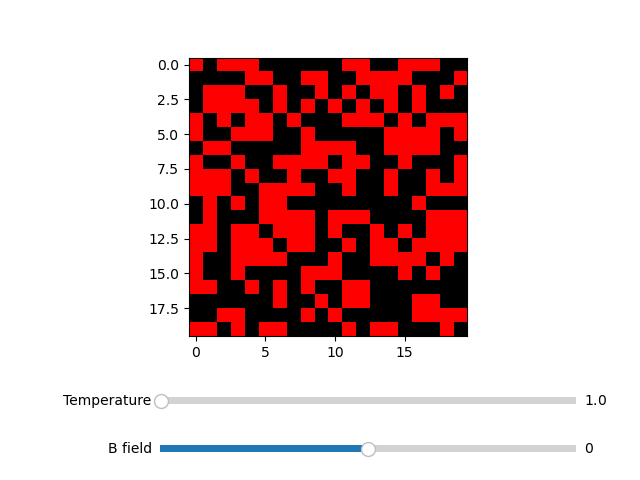

In [23]:
g = generate_simulation_static(config)

In [25]:
g.event_source.stop()   #TO KILL SIMULATION

Autocorrelation time function also works quite well (I think.)

In [22]:
compute_ACT(config)

142

Regarding warm-up time, it relies on cycle length, but optimal cycle length computation requires a warmed up argument, so we can just warm up a configuration arbitrarily and retroactively check for stable cyle and logical cycle length.

Anyway, this is not the ultimate goal of this project.